In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn.model_selection import LeaveOneOut, KFold
from binaryapproximator import *
from sklearn.metrics import zero_one_loss, log_loss
import cProfile
import re


In [2]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['sign(Delta E)', 'Delta E', 'IP(A)', 'EA(A)', 'H(A)', 'L(A)', 'rs(A)', 'rp(A)', 'rd(A)', 'IP(B)', 'EA(B)', 'H(B)', 'L(B)', 'rs(B)', 'rp(B)', 'rd(B)', 'EN(A)', 'EN(B)']]
X_r = octet_selected[['IP(A)', 'EA(A)', 'H(A)', 'L(A)', 'rs(A)', 'rp(A)', 'rd(A)', 'IP(B)', 'EA(B)', 'H(B)', 'L(B)', 'rs(B)', 'rp(B)', 'rd(B)', 'EN(A)', 'EN(B)']].to_numpy()
y_delta = octet_selected[['Delta E']].to_numpy()
y = octet_selected[['sign(Delta E)']].to_numpy()
y = np.where( y==1, np.float32(1), np.float32(0))
X,_,_ = normalise_data(X_r)


In [4]:

input = 16
hidden1 = 32
hidden2 = 32
# hidden3 = 32
output = 1
nll_loss = nn.BCELoss()
loo_cv = LeaveOneOut()
n_splits = 10
n_reps = 10
kf_cv = KFold(n_splits=n_splits, shuffle=True)


# Method 0: Regular NN Training
1. Initialise the Weights
    
Do for $t < \tau$:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

In [99]:
# Leave One Out CV
model_finals_0_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_0_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_0_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_0_std_log_loo = np.empty(shape= (82), dtype=object)
train_loss_0_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_0_std_log_loo = np.empty(shape= (10), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_base_log = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=False)
        tr = TrainNN(model=model_base_log, x=X[train_ind], y=y[train_ind], gradient_threshold=0.001, learning_rate=0.01)
        loss_func = LossFunction(bce=True)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_0_log_loo[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_0_log_loo[reps, set_ind] = log_loss(y[test_ind],y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_0_log_loo[reps, set_ind] = log_loss(y[train_ind],y_pred_train, labels=[0,1])

        set_ind  += 1
        

for samp in range(82):
    test_loss_0_std_log_loo[samp] = test_loss_0_log_loo[:,samp].std()

for reps in range(n_reps):
    train_loss_0_std_log_loo[reps] = train_loss_0_log_loo[reps,:].std()


0
Early stopping at Epoch 399 due to small gradients.
Early stopping at Epoch 337 due to small gradients.
Early stopping at Epoch 333 due to small gradients.
Early stopping at Epoch 310 due to small gradients.
Early stopping at Epoch 324 due to small gradients.
Early stopping at Epoch 325 due to small gradients.
Early stopping at Epoch 327 due to small gradients.
Early stopping at Epoch 383 due to small gradients.
Early stopping at Epoch 419 due to small gradients.
Early stopping at Epoch 354 due to small gradients.
Early stopping at Epoch 387 due to small gradients.
Early stopping at Epoch 322 due to small gradients.
Early stopping at Epoch 382 due to small gradients.
Early stopping at Epoch 372 due to small gradients.
Early stopping at Epoch 331 due to small gradients.
Early stopping at Epoch 367 due to small gradients.
Early stopping at Epoch 341 due to small gradients.
Early stopping at Epoch 329 due to small gradients.
Early stopping at Epoch 413 due to small gradients.
Early stop

In [101]:
# KFold CV
model_finals_0_log = np.empty(shape= (n_reps, n_splits), dtype=object)
epoch_losses_0_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_0_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_0_std_log = np.empty(shape= (n_splits), dtype=object)
train_loss_0_log = np.empty(shape= (n_reps, n_splits), dtype=object)
train_loss_0_std_log = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in kf_cv.split(X):
        model_base_log = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=False)
        tr = TrainNN(model=model_base_log, x=X[train_ind], y=y[train_ind], gradient_threshold=0.001, learning_rate=0.001)
        loss_func = LossFunction(bce=True)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_0_log[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_0_log[reps, set_ind] = log_loss(y[test_ind],y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_0_log[reps, set_ind] = log_loss(y[train_ind],y_pred_train, labels=[0,1])

        set_ind  += 1
        

for fold in range(n_splits):
    test_loss_0_std_log[fold] = test_loss_0_log[:,fold].std()

for reps in range(n_reps):
    train_loss_0_std_log[reps] = train_loss_0_log[reps,:].std()


0
Early stopping at Epoch 2619 due to small gradients.
Early stopping at Epoch 2351 due to small gradients.
Early stopping at Epoch 2777 due to small gradients.
Early stopping at Epoch 2576 due to small gradients.
Early stopping at Epoch 2730 due to small gradients.
Early stopping at Epoch 2683 due to small gradients.
Early stopping at Epoch 2329 due to small gradients.
Early stopping at Epoch 2522 due to small gradients.
Early stopping at Epoch 2667 due to small gradients.
Early stopping at Epoch 2626 due to small gradients.
1
Early stopping at Epoch 2734 due to small gradients.
Early stopping at Epoch 2515 due to small gradients.
Early stopping at Epoch 2614 due to small gradients.
Early stopping at Epoch 2336 due to small gradients.
Early stopping at Epoch 2658 due to small gradients.
Early stopping at Epoch 2608 due to small gradients.
Early stopping at Epoch 2491 due to small gradients.
Early stopping at Epoch 2613 due to small gradients.
Early stopping at Epoch 2588 due to small 

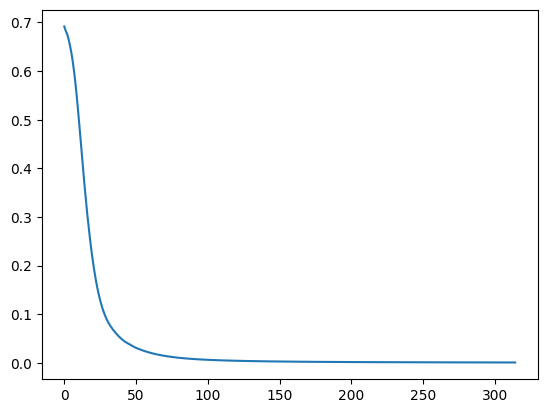

In [100]:
plt.plot(epoch_loss)

In [ ]:
model_base_0 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=False)
tr = TrainNN(model=model_base_log, x=X, y=y, gradient_threshold=0.001, learning_rate=0.001)
loss_func = LossFunction(bce=True)
model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
# model_finals_0[reps, set_ind] = model_final
epoch_losses_0_log[reps, set_ind] = epoch_loss
y_pred_test = model_final.predict(X)
test_loss_0_log[reps, set_ind] = log_loss(y,y_pred_test, labels=[0,1])

In [7]:
# base_dict = dict()
# for name, param in model_base_log.named_parameters():
#     base_dict[name] = param.detach().numpy().flatten()

# base_df_0_log = pd.DataFrame.from_dict(base_dict, orient='index')
# base_df_0_log.to_csv('base_model_0_log.csv')

# Method 1: Adding L1 and Bianry Penalty + Binarising the Proposition Layer After Full Training
1. Initialise the Weights
    
Do for $t < \tau$:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred}, p_{l_1}(\theta_t), p_{binary}(W_t))$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$

In [80]:
# search for l1 and binary lambda
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=529)
lambda_range = np.logspace(-5, 2, num=8)
valid_loss_per_pair_lambda = np.zeros(len(lambda_range))
epoch_loss_ = np.empty(shape= (40), dtype=object)
title = np.empty(shape= (40), dtype=object)
i = 0
for l1_ind, l1 in enumerate(lambda_range):
    # for lb_ind, lb in enumerate(lambda_range):
        valid_loss_sig = []
        for train_ind, valid_ind in kf.split(X):
            model_ = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
            layer2_param = getattr(model_, 'hidden2')
            layer2_param.weight.data = torch.randint(-1, 2, size=layer2_param.weight.size(), dtype=torch.float32)
            tr = TrainNN(model=model_, x=X[train_ind], y=y[train_ind], gradient_threshold=0.001, learning_rate=0.0001, n_epochs=8000)
            loss_func = LossFunction(bce=True, l1_lambda=l1, binary_lambda=l1)
            model_final, epoch_loss_[i] = tr.nn_training(loss_func=loss_func)
            title[i] = ['l1: '+str(l1)+' lb: '+str(l1)]
            model_final.binarise_model()
            y_pred_test = model_final.predict(X[valid_ind])
            valid_loss_sig.append(np.mean((y[valid_ind]-y_pred_test)**2))
            i += 1
        valid_loss_per_pair_lambda[l1_ind] = np.mean(valid_loss_sig)

End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number


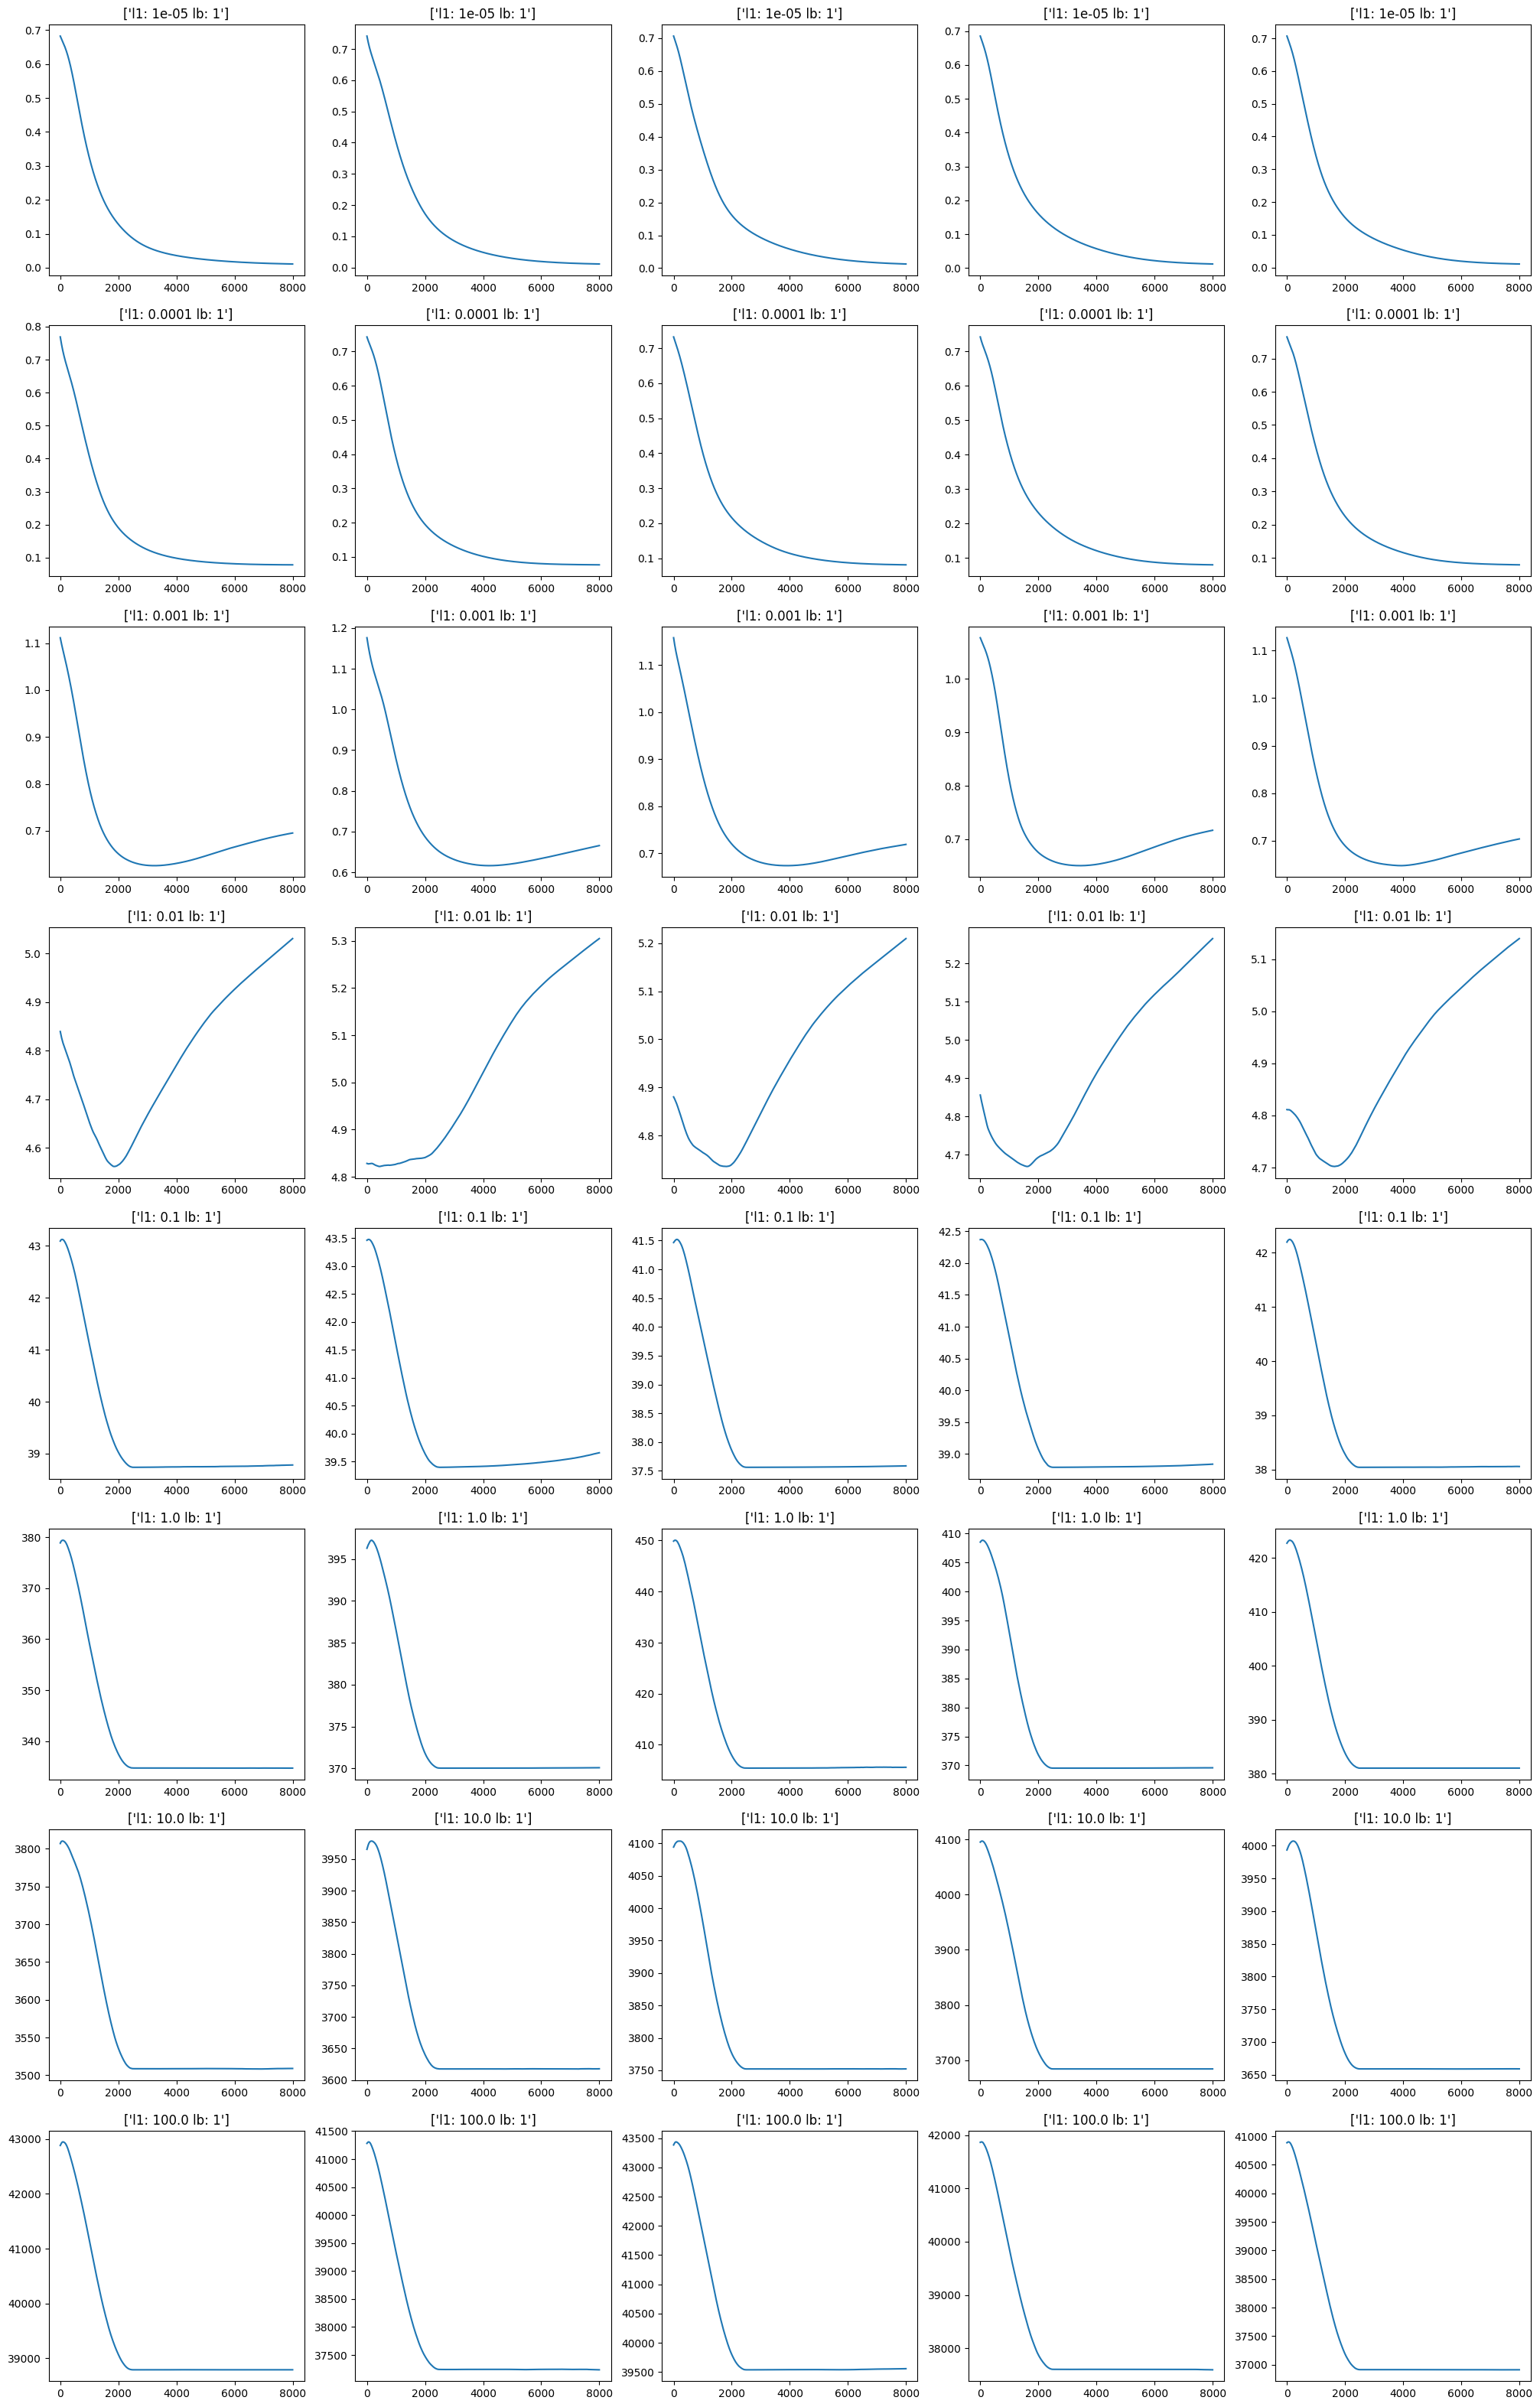

In [81]:
fig, ax = plt.subplots(8, 5, figsize=(25, 40))
n=0
for i in range(8):
    for j in range(5):
        ax[i,j].plot(epoch_loss_[n])
        ax[i,j].set_title(title[n])
        n += 1


In [97]:
# Leave One Out CV
penalty_lambda = lambda_range[np.unravel_index(np.argmin(valid_loss_per_pair_lambda), valid_loss_per_pair_lambda.shape)[0]]
# binary_lambda_sig_1 = lambda_range[np.unravel_index(np.argmin(valid_loss_per_pair_lambda_sig), valid_loss_per_pair_lambda_sig.shape)[1]]
model_finals_1_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_1_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_1_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_1_std_log_loo = np.empty(shape= (82), dtype=object)
train_loss_1_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_1_std_log_loo = np.empty(shape= (10), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_1 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
        tr = TrainNN(model=model_1, x=X[train_ind], y=y[train_ind], gradient_threshold=0.005, learning_rate=0.0001, n_epochs=20000)
        loss_func = LossFunction(bce=True, l1_lambda=penalty_lambda, binary_lambda=penalty_lambda)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        model_final.binarise_model()
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_1_log_loo[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_1_log_loo[reps, set_ind] = np.mean((y[test_ind]-y_pred_test)**2)
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_1_log_loo[reps, set_ind] = np.mean((y[train_ind]-y_pred_train)**2)

        set_ind  += 1

for samp in range(82):
    test_loss_1_std_log_loo[samp] = test_loss_1_log_loo[:,samp].std()

for reps in range(n_reps):
    train_loss_1_std_log_loo[reps] = train_loss_1_log_loo[reps,:].std()

0
Early stopping at Epoch 8044 due to small gradients.
Early stopping at Epoch 7724 due to small gradients.
Early stopping at Epoch 8104 due to small gradients.
Early stopping at Epoch 8319 due to small gradients.
Early stopping at Epoch 7751 due to small gradients.
Early stopping at Epoch 8257 due to small gradients.
Early stopping at Epoch 8054 due to small gradients.
Early stopping at Epoch 8224 due to small gradients.
Early stopping at Epoch 7993 due to small gradients.
Early stopping at Epoch 7849 due to small gradients.
Early stopping at Epoch 8638 due to small gradients.
Early stopping at Epoch 8066 due to small gradients.
Early stopping at Epoch 8048 due to small gradients.
Early stopping at Epoch 8143 due to small gradients.
Early stopping at Epoch 9439 due to small gradients.
Early stopping at Epoch 8005 due to small gradients.
Early stopping at Epoch 8181 due to small gradients.
Early stopping at Epoch 7658 due to small gradients.
Early stopping at Epoch 8075 due to small gr

In [94]:
# KFold CV
penalty_lambda = lambda_range[np.unravel_index(np.argmin(valid_loss_per_pair_lambda), valid_loss_per_pair_lambda.shape)[0]]
# binary_lambda_sig_1 = lambda_range[np.unravel_index(np.argmin(valid_loss_per_pair_lambda_sig), valid_loss_per_pair_lambda_sig.shape)[1]]
model_finals_1_log = np.empty(shape= (n_reps, n_splits), dtype=object)
epoch_losses_1_sig_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_1_sig_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_1_std_sig_log = np.empty(shape= (n_splits), dtype=object)
train_loss_1_sig_log = np.empty(shape= (n_reps, n_splits), dtype=object)
train_loss_1_std_sig_log = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in kf_cv.split(X):
        model_1 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
        layer2_param = getattr(model_1, 'hidden2')
        layer2_param.weight.data = torch.randint(-1, 2, size=layer2_param.weight.size(), dtype=torch.float32)
        tr = TrainNN(model=model_1, x=X[train_ind], y=y[train_ind], gradient_threshold=0.005, learning_rate=0.0001, n_epochs=25000)
        loss_func = LossFunction(bce=True, l1_lambda=penalty_lambda, binary_lambda=penalty_lambda)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        model_final.binarise_model()
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_1_sig_log[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_1_sig_log[reps, set_ind] = np.mean((y[test_ind]-y_pred_test)**2)
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_1_sig_log[reps, set_ind] = np.mean((y[train_ind]-y_pred_train)**2)

        set_ind  += 1

for fold in range(n_splits):
    test_loss_1_std_sig_log[fold] = test_loss_1_sig_log[:,fold].std()

for reps in range(n_reps):
    train_loss_1_std_sig_log[reps] = train_loss_1_sig_log[reps,:].std()

0
Early stopping at Epoch 8394 due to small gradients.
Early stopping at Epoch 8703 due to small gradients.
Early stopping at Epoch 8098 due to small gradients.
Early stopping at Epoch 8556 due to small gradients.
Early stopping at Epoch 8395 due to small gradients.
Early stopping at Epoch 8275 due to small gradients.
Early stopping at Epoch 8051 due to small gradients.
Early stopping at Epoch 8035 due to small gradients.
Early stopping at Epoch 8378 due to small gradients.
Early stopping at Epoch 8365 due to small gradients.
1
Early stopping at Epoch 7654 due to small gradients.
Early stopping at Epoch 8921 due to small gradients.
Early stopping at Epoch 8419 due to small gradients.
Early stopping at Epoch 8244 due to small gradients.
Early stopping at Epoch 7660 due to small gradients.
Early stopping at Epoch 8471 due to small gradients.
Early stopping at Epoch 8212 due to small gradients.
Early stopping at Epoch 8169 due to small gradients.
Early stopping at Epoch 8496 due to small 

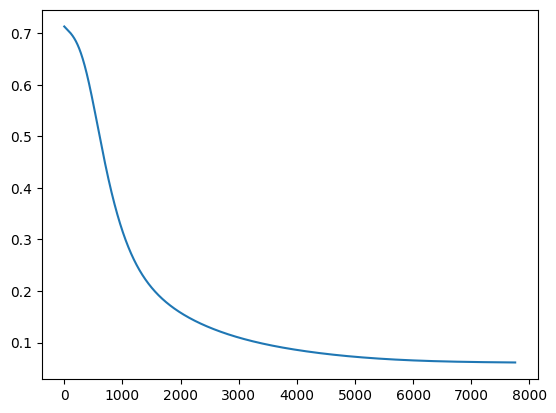

In [98]:
plt.plot(epoch_loss)

# Method 2: Binarising the Proposition Layer After Training
1. Initialise the Weights
    
Do for $t < \tau$:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarise(W_{\tau})$

In [104]:
# Leave One Out CV
model_finals_2_log = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_2_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_2_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_2_std_log_loo = np.empty(shape= (82), dtype=object)
train_loss_2_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_2_std_log_loo = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_2 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
        layer2_param = getattr(model_2, 'hidden2')
        layer2_param.weight.data = torch.randint(-1, 2, size=layer2_param.weight.size(), dtype=torch.float32)
        tr = TrainNN(model=model_2, x=X[train_ind], y=y[train_ind], gradient_threshold=0.001, learning_rate=0.0001)
        loss_func = LossFunction(bce=True)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        model_final.binarise_model(layer=2)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_2_log_loo[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_2_log_loo[reps, set_ind] = log_loss(y[test_ind], y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_2_log_loo[reps, set_ind] = log_loss(y[train_ind], y_pred_train, labels=[0,1])

        set_ind  += 1

for samp in range(82):
    test_loss_2_std_log_loo[samp] = test_loss_2_log_loo[:,samp].std()

for reps in range(n_reps):
    train_loss_2_std_log_loo[reps] = train_loss_2_log_loo[reps,:].std()

0
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch numbe

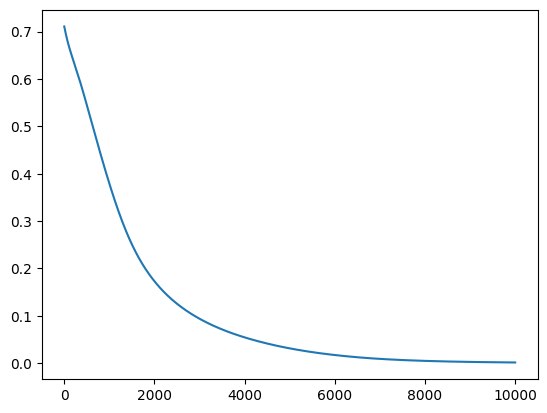

In [105]:
plt.plot(epoch_loss)

In [108]:
# KFold CV
model_finals_2_log = np.empty(shape= (n_reps, n_splits), dtype=object)
epoch_losses_2_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_2_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_2_std_log = np.empty(shape= (n_splits), dtype=object)
train_loss_2_log = np.empty(shape= (n_reps, n_splits), dtype=object)
train_loss_2_std_log = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in kf_cv.split(X):
        model_2 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
        layer2_param = getattr(model_2, 'hidden2')
        layer2_param.weight.data = torch.randint(-1, 2, size=layer2_param.weight.size(), dtype=torch.float32)
        tr = TrainNN(model=model_2, x=X[train_ind], y=y[train_ind], gradient_threshold=0.001, learning_rate=0.0001)
        loss_func = LossFunction(bce=True)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        model_final.binarise_model(layer=2)
        # model_finals_0[reps, set_ind] = model_final
        epoch_losses_2_log[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_2_log[reps, set_ind] = log_loss(y[test_ind], y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_2_log[reps, set_ind] = log_loss(y[train_ind], y_pred_train, labels=[0,1])

        set_ind  += 1

for fold in range(n_splits):
    test_loss_2_std_log[fold] = test_loss_2_log[:,fold].std()

for reps in range(n_reps):
    train_loss_2_std_log[reps] = train_loss_2_log[reps,:].std()

0
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
1
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
2
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
3
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
4
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epo

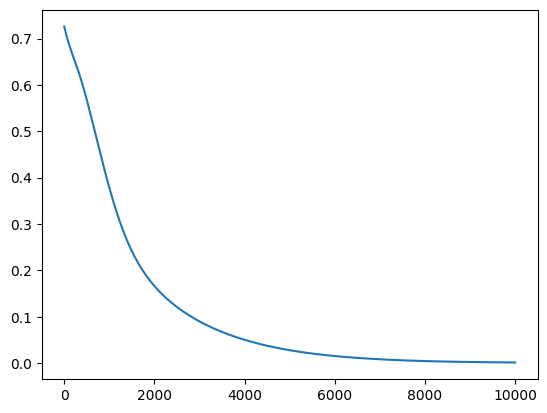

In [107]:
plt.plot(epoch_loss)

# Method 3: Sparsified the Base NN (with adding L1 Penalty)
1. Initialise the Weights
    
Do for $t < \tau$:

2. $y_{pred} = Model(X,W_t, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred}, p_{l_1}(\theta_t))$  
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

In [112]:
kf = KFold(n_splits=4, shuffle=True, random_state=529)
lambda_range = np.logspace(-5, 2, num=8)
valid_loss_per_lambda = []
for l in lambda_range:
    valid_loss_ = []
    for train_ind, valid_ind in kf.split(X):
        model_ = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=True)
        tr = TrainNN(model=model_, x=X[train_ind], y=y[train_ind], gradient_threshold=0.005, learning_rate=0.001, n_epochs=10000)
        loss_func = LossFunction(bce=True, l1_lambda=l)
        model_final, epoch_losss_ = tr.nn_training(loss_func=loss_func)
        y_pred_valid = model_final.predict(X[valid_ind])
        valid_loss_.append(log_loss(y[valid_ind], y_pred_valid, labels=[0,1]))
    valid_loss_per_lambda.append(np.mean(valid_loss_))
lambda_range[valid_loss_per_lambda.index(min(valid_loss_per_lambda))]

Early stopping at Epoch 1142 due to small gradients.
Early stopping at Epoch 1216 due to small gradients.
Early stopping at Epoch 1210 due to small gradients.
Early stopping at Epoch 1203 due to small gradients.
Early stopping at Epoch 1663 due to small gradients.
Early stopping at Epoch 1849 due to small gradients.
Early stopping at Epoch 2001 due to small gradients.
Early stopping at Epoch 1802 due to small gradients.
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number
End of epoch number


0.0001

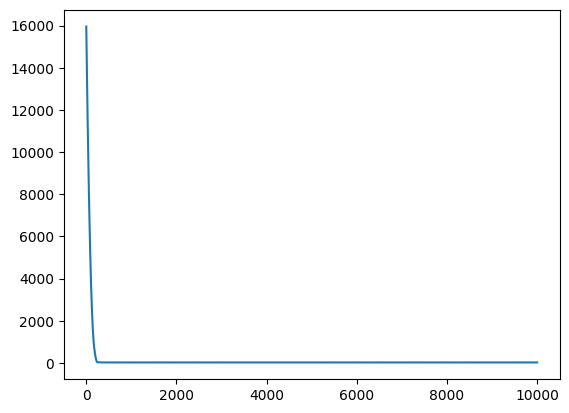

In [113]:
plt.plot(epoch_losss_)

In [117]:
# Leave One Out CV
l1_lambda_3 = lambda_range[valid_loss_per_lambda.index(min(valid_loss_per_lambda))]   # lambda is 1.6681005372000593e-05
model_finals_3_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
epoch_losses_3_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_3_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
test_loss_3_std_log_loo = np.empty(shape= (82), dtype=object)
train_loss_3_log_loo = np.empty(shape= (n_reps, 82), dtype=object)
train_loss_3_std_log_loo = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in loo_cv.split(X):
        model_3 = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=False)
        tr = TrainNN(model=model_3, x=X[train_ind], y=y[train_ind], gradient_threshold=0.005, learning_rate=0.001)
        loss_func = LossFunction(bce=True, l1_lambda=l1_lambda_3)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        # model_finals_3[reps, set_ind] = model_final
        epoch_losses_3_log_loo[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_3_log_loo[reps, set_ind] = log_loss(y[test_ind], y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_3_log_loo[reps, set_ind] = log_loss(y[train_ind], y_pred_train, labels=[0,1])

        set_ind  += 1

for samp in range(82):
    test_loss_3_std_log_loo[samp] = test_loss_3_log_loo[:,samp].std()

for reps in range(n_reps):
    train_loss_3_std_log_loo[reps] = train_loss_3_log_loo[reps,:].std()

0
Early stopping at Epoch 2075 due to small gradients.
Early stopping at Epoch 2017 due to small gradients.
Early stopping at Epoch 2197 due to small gradients.
Early stopping at Epoch 2135 due to small gradients.
Early stopping at Epoch 2011 due to small gradients.
Early stopping at Epoch 2024 due to small gradients.
Early stopping at Epoch 1992 due to small gradients.
Early stopping at Epoch 2509 due to small gradients.
Early stopping at Epoch 1863 due to small gradients.
Early stopping at Epoch 1863 due to small gradients.
Early stopping at Epoch 2193 due to small gradients.
Early stopping at Epoch 1883 due to small gradients.
Early stopping at Epoch 2101 due to small gradients.
Early stopping at Epoch 1974 due to small gradients.
Early stopping at Epoch 2191 due to small gradients.
Early stopping at Epoch 1832 due to small gradients.
Early stopping at Epoch 1989 due to small gradients.
Early stopping at Epoch 1757 due to small gradients.
Early stopping at Epoch 1861 due to small gr

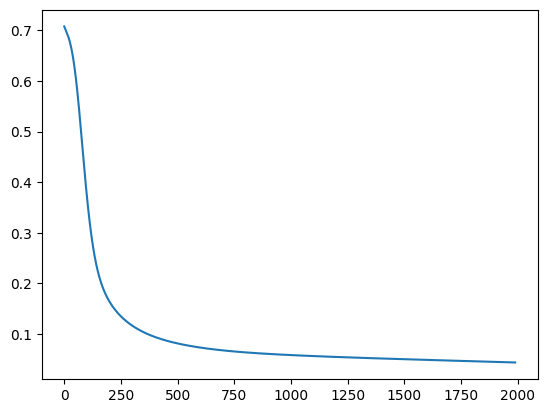

In [118]:
plt.plot(epoch_loss)

In [119]:
# KFold CV
l1_lambda_3 = lambda_range[valid_loss_per_lambda.index(min(valid_loss_per_lambda))]  
model_finals_3_log = np.empty(shape= (n_reps, n_splits), dtype=object)
epoch_losses_3_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_3_log = np.empty(shape= (n_reps, n_splits), dtype=object)
test_loss_3_std_log = np.empty(shape= (n_splits), dtype=object)
train_loss_3_log = np.empty(shape= (n_reps, n_splits), dtype=object)
train_loss_3_std_log = np.empty(shape= (n_reps), dtype=object)
for reps in range(n_reps):
    print(reps)
    set_ind = 0
    for train_ind, test_ind in kf_cv.split(X):
        model_3_log = GeneralLogisticNN(input_size=input, hidden_size1=hidden1, hidden_size2=hidden2, output_size=output, balancing_bias=False)
        tr = TrainNN(model=model_3_log, x=X[train_ind], y=y[train_ind], gradient_threshold=0.005, learning_rate=0.001)
        loss_func = LossFunction(bce=True, l1_lambda=l1_lambda_3)
        model_final, epoch_loss = tr.nn_training(loss_func=loss_func)
        # model_finals_3[reps, set_ind] = model_final
        epoch_losses_3_log[reps, set_ind] = epoch_loss
        y_pred_test = model_final.predict(X[test_ind])
        test_loss_3_log[reps, set_ind] = log_loss(y[test_ind], y_pred_test, labels=[0,1])
        y_pred_train = model_final.predict(X[train_ind])
        train_loss_3_log[reps, set_ind] = log_loss(y[train_ind], y_pred_train, labels=[0,1])

        set_ind  += 1

for fold in range(n_splits):
    test_loss_3_std_log[fold] = test_loss_3_log[:,fold].std()

for reps in range(n_reps):
    train_loss_3_std_log[reps] = train_loss_3_log[reps,:].std()


0
Early stopping at Epoch 2103 due to small gradients.
Early stopping at Epoch 1982 due to small gradients.
Early stopping at Epoch 1982 due to small gradients.
Early stopping at Epoch 1818 due to small gradients.
Early stopping at Epoch 1957 due to small gradients.
Early stopping at Epoch 2496 due to small gradients.
Early stopping at Epoch 1923 due to small gradients.
Early stopping at Epoch 2397 due to small gradients.
Early stopping at Epoch 1872 due to small gradients.
Early stopping at Epoch 2017 due to small gradients.
1
Early stopping at Epoch 1868 due to small gradients.
Early stopping at Epoch 2009 due to small gradients.
Early stopping at Epoch 2037 due to small gradients.
Early stopping at Epoch 1871 due to small gradients.
Early stopping at Epoch 1547 due to small gradients.
Early stopping at Epoch 1665 due to small gradients.
Early stopping at Epoch 1744 due to small gradients.
Early stopping at Epoch 1875 due to small gradients.
Early stopping at Epoch 2425 due to small 

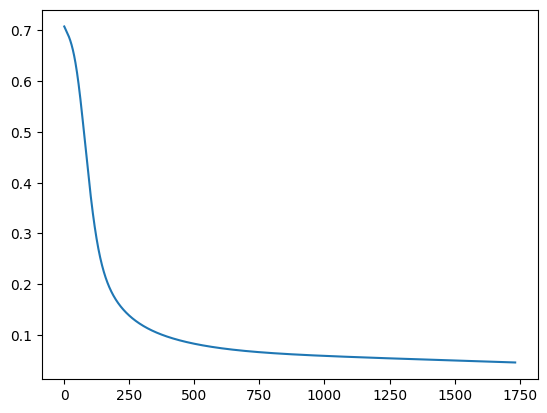

In [120]:
plt.plot(epoch_loss)

In [24]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# fig.suptitle(' Scenario 3: Base NN + L1 Penalty ', fontsize=15)
# ax.errorbar(y_delta, test_loss_3_log.mean(axis=0), yerr=np.array(test_loss_3_std_log)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Test')
# # ax.scatter(range(82), train_loss_0.mean(axis=0), label='Train')
# ax.set_xlabel("$\Delta$E")
# ax.set_ylabel("loss")
# # ax.set_yscale("log")
# ax.set_title(f'Mean and Std of Log Loss for Test Set over {n_reps} Repetitions', fontsize=10)
# ax.legend()

In [25]:
# base_dict = dict()
# for name, param in model_3_log.named_parameters():
#     base_dict[name] = param.detach().numpy().flatten()

# base_df_3_log = pd.DataFrame.from_dict(base_dict, orient='index')
# base_df_3_log.to_csv('base_model_3_log.csv')

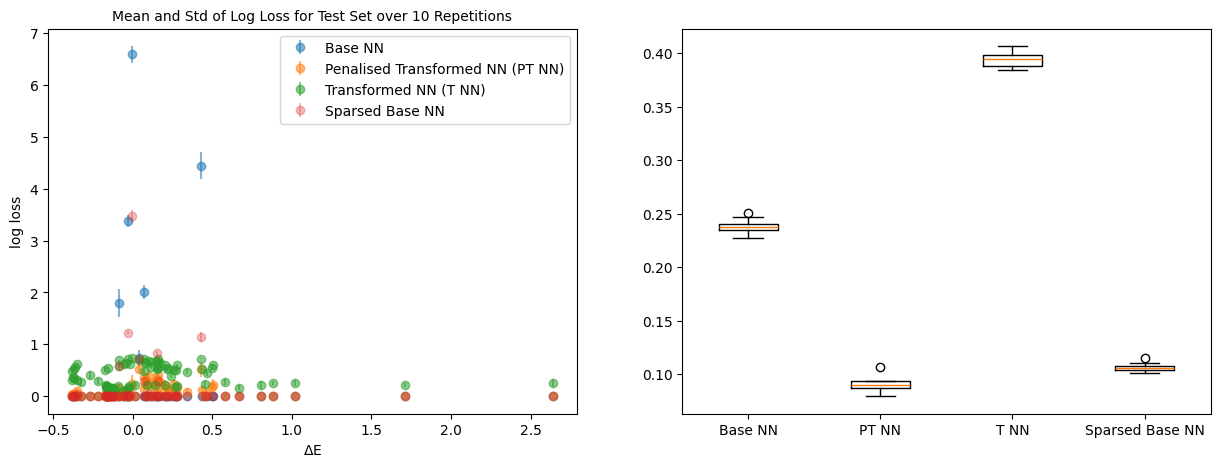

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle(' Scenario 3: Base NN + L1 Penalty ', fontsize=15)
ax[0].errorbar(y_delta, test_loss_0_log_loo.mean(axis=0), yerr=np.array(test_loss_0_std_log_loo)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Base NN', alpha=0.55)
ax[0].errorbar(y_delta, test_loss_1_log_loo.mean(axis=0), yerr=np.array(test_loss_1_std_log_loo)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Penalised Transformed NN (PT NN)', alpha=0.55)
ax[0].errorbar(y_delta, test_loss_2_log_loo.mean(axis=0), yerr=np.array(test_loss_2_std_log_loo)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Transformed NN (T NN)', alpha=0.55)
ax[0].errorbar(y_delta, test_loss_3_log_loo.mean(axis=0), yerr=np.array(test_loss_3_std_log_loo)*1.96/(n_reps**0.5), marker='o', linestyle=' ', label='Sparsed Base NN', alpha=0.3)
# ax.scatter(range(82), train_loss_0.mean(axis=0), label='Train')
ax[0].set_xlabel("$\Delta$E")
ax[0].set_ylabel("log loss")
# ax.set_yscale("log")
ax[0].set_title(f'Mean and Std of Log Loss for Test Set over {n_reps} Repetitions', fontsize=10)
ax[0].legend()
data = [test_loss_0_log_loo.mean(axis=1),test_loss_1_log_loo.mean(axis=1), test_loss_2_log_loo.mean(axis=1), test_loss_3_log_loo.mean(axis=1)]
labels = ['Base NN', 'PT NN', 'T NN', 'Sparsed Base NN']
# ax[1] = fig.add_axes([0, 0, 1, 1])
bp = ax[1].boxplot(data)
ax[1].set_xticklabels(labels, rotation=0, ha="center")
plt.show()

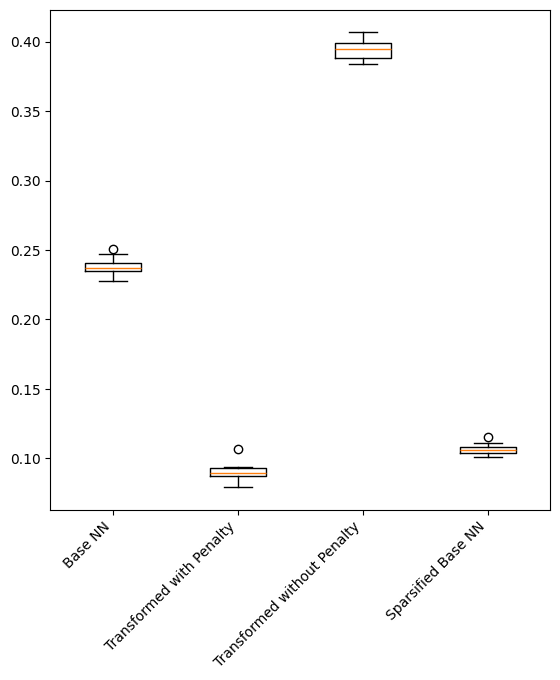

In [123]:
data = [test_loss_0_log_loo.mean(axis=1),test_loss_1_log_loo.mean(axis=1), test_loss_2_log_loo.mean(axis=1), test_loss_3_log_loo.mean(axis=1)]
labels = ['Base NN', 'Penalised Transformed NN', 'Transformed NN', 'Sparsed Base NN']
fig = plt.figure(figsize =(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.show()